# 함수형 API

**저자:** [fchollet](https://twitter.com/fchollet)  
**생성일:** 2019/03/01  
**최종편집일:** 2023/06/25  
**설명:** 함수형 API에 대한 전체 가이드.

## 셋업

In [1]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"

In [34]:
from keras import backend
print(backend.backend())

jax


In [2]:
import numpy as np
import keras
from keras import layers
from keras import ops

## 소개

Keras _함수형 API_ 는 [`keras.Sequential`](https://codecompose7.github.io/keras-doc-kr.github.io/api/models/sequential#sequential-class) API보다 더 유연한 모델을 만드는 방법입니다.
함수형 API는 비선형 토폴로지, 공유 레이어, 심지어 여러 입력이나 출력이 있는 모델을 처리할 수 있습니다.

주요 아이디어는 딥러닝 모델이 일반적으로 레이어의 방향성 비순환 그래프(DAG)라는 것입니다.
따라서 함수형 API는 _레이어 그래프_ 를 빌드하는 방법입니다.

다음 모델을 고려하세요.

```
(입력: 784 차원 벡터)
       ↧
[Dense (64 유닛, relu 활성화)]
       ↧
[Dense (64 유닛, relu 활성화)]
       ↧
[Dense (10 유닛, softmax 활성화)]
       ↧
(출력: 10개 클래스에 대한 확률 분포의 로짓)
```

이것은 3개의 레이어가 있는 기본 그래프입니다.
함수형 API를 사용하여 이 모델을 빌드하려면, 먼저 입력 노드를 만듭니다.

In [3]:
inputs = keras.Input(shape=(784,))

데이터 모양은 784차원 벡터로 설정됩니다.
각 샘플의 모양만 지정되므로, 배치 크기는 항상 생략됩니다.

예를 들어, `(32, 32, 3)` 모양의 이미지 입력이 있는 경우, 다음을 사용합니다.

In [4]:
# 단지 데모 목적입니다.
img_inputs = keras.Input(shape=(32, 32, 3))

반환된 `inputs`에는 모델에 공급하는 입력 데이터의 모양과 `dtype`에 대한 정보가 들어 있습니다.
모양은 다음과 같습니다.

In [5]:
inputs.shape

(None, 784)

dtype은 다음과 같습니다.

In [6]:
inputs.dtype

'float32'

이 `inputs` 객체에서 레이어를 호출하여, 레이어 그래프에 새 노드를 만듭니다.

In [7]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

"레이어 호출" 작업은 "inputs"에서 생성한 이 레이어로 화살표를 그리는 것과 같습니다.
입력을 `dense` 레이어로 "전달"하고 출력으로 `x`를 얻습니다.

레이어 그래프에 몇 개의 레이어를 더 추가해 보겠습니다.

In [8]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

이 시점에서, 그래프 레이어에 입력과 출력을 지정하여 `Model`을 생성할 수 있습니다.

In [9]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

모델 요약이 어떤지 살펴보겠습니다.

In [10]:
model.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,050 (215.04 KB)

 Trainable params: 55,050 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

모델을 그래프로 표시할 수도 있습니다.

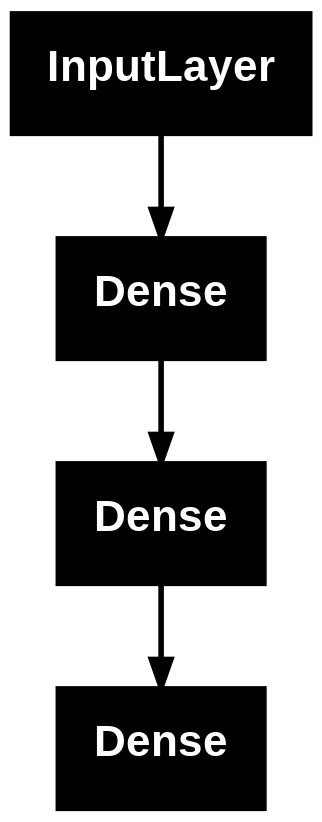

In [11]:
keras.utils.plot_model(model, "my_first_model.png")

그리고, 선택적으로, 각 레이어의 입력 및 출력 모양을 그려진 그래프에 표시합니다.

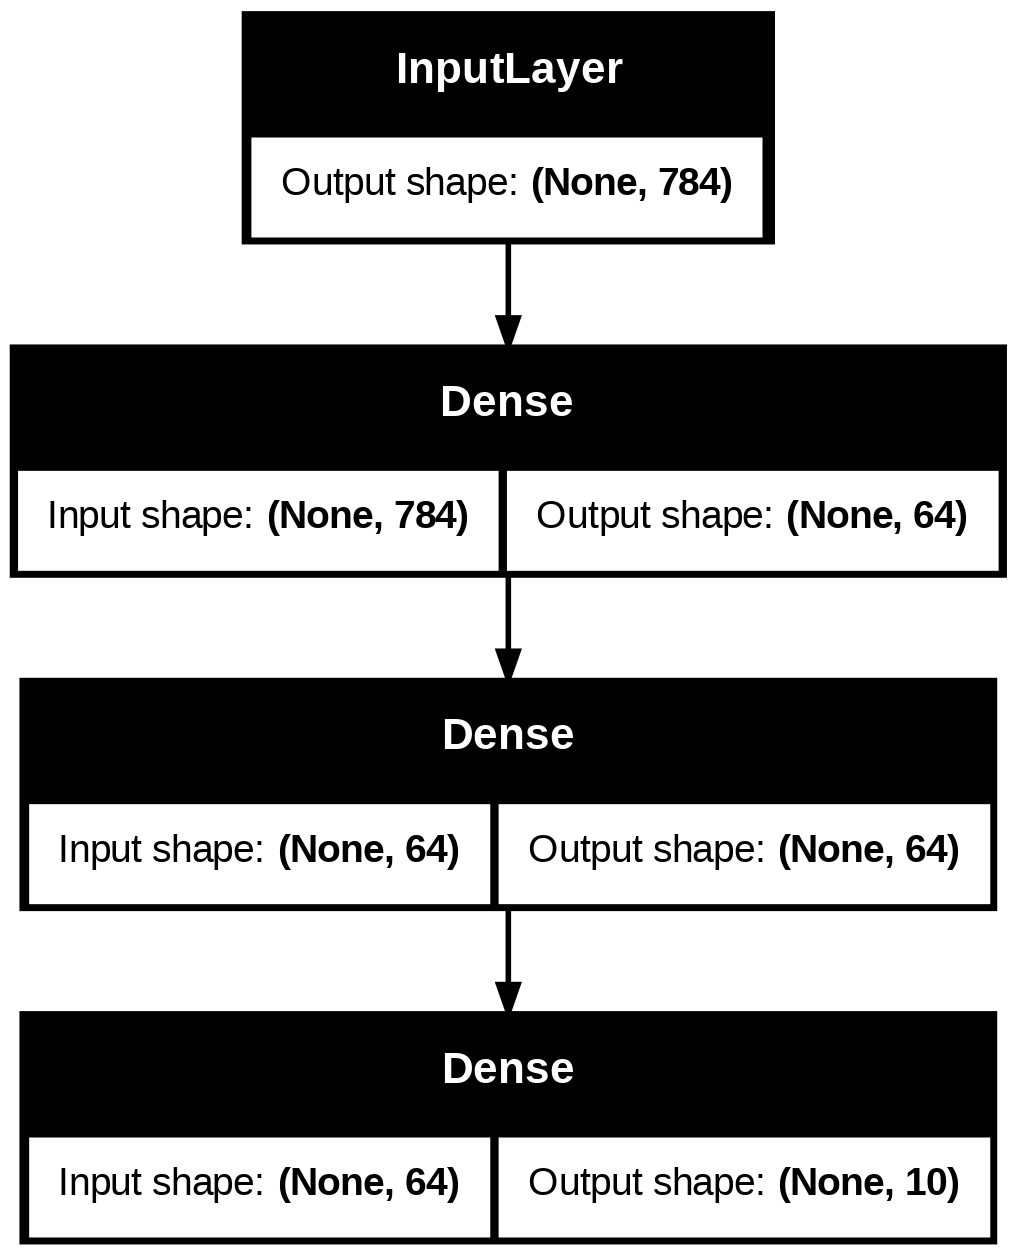

In [12]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

이 그림과 코드는 거의 동일합니다. 코드 버전에서는, 연결 화살표가 호출 연산으로 대체되었습니다.

"레이어 그래프"는 딥러닝 모델에 대한 직관적인 정신적 이미지이며,
함수형 API는 이를 밀접하게 반영하는 모델을 만드는 방법입니다.

## 트레이닝, 평가 및 추론

트레이닝, 평가 및 추론은 함수형 API를 사용하여 구축된 모델에서,
`Sequential` 모델과 정확히 동일한 방식으로 작동합니다.

`Model` 클래스는 빌트인 학습 루프(`fit()` 메서드)와 빌트인 평가 루프(`evaluate()` 메서드)를 제공합니다.
이러한 루프를 쉽게 커스터마이즈하여 고유한 트레이닝 루틴을 구현할 수 있습니다.
`fit()`에서 발생하는 작업을 커스터마이즈하는 방법에 대한 가이드도 참조하세요.

* [TensorFlow로 커스터마이즈 트레이닝 단계 작성](https://codecompose7.github.io/keras-doc-kr.github.io/guides/custom_train_step_in_tensorflow/)
* [JAX로 커스터마이즈 트레이닝 단계 작성](https://codecompose7.github.io/keras-doc-kr.github.io/guides/custom_train_step_in_jax/)
* [PyTorch로 커스터마이즈 트레이닝 단계 작성](https://codecompose7.github.io/keras-doc-kr.github.io/guides/custom_train_step_in_torch/)

여기서, MNIST 이미지 데이터를 로드하고, 벡터로 reshape하고,
모델을 데이터에 맞춘 다음 (검증 분할에서 성능을 모니터링하는 동안),
테스트 데이터에서 모델을 평가합니다.

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/2
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8297 - loss: 0.5870 - val_accuracy: 0.9462 - val_loss: 0.1849
Epoch 2/2
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.9495 - loss: 0.1678 - val_accuracy: 0.9542 - val_loss: 0.1532
313/313 - 1s - 2ms/step - accuracy: 0.9496 - loss: 0.1604
Test loss: 0.16038869321346283
Test accuracy: 0.9496000409126282


자세한 내용은 [트레이닝 및 평가](https://codecompose7.github.io/keras-doc-kr.github.io/guides/training_with_built_in_methods/) 가이드를 참조하세요.

## 저장 및 직렬화

모델 저장 및 직렬화는 `Sequential` 모델과 마찬가지로,
함수형 API를 사용하여 빌드한 모델에 대해 동일한 방식으로 작동합니다.
함수형 모델을 저장하는 표준 방법은 `model.save()`를 호출하여,
전체 모델을 단일 파일로 저장하는 것입니다.
나중에 모델을 빌드한 코드를 더 이상 사용할 수 없더라도,
이 파일에서 동일한 모델을 다시 만들 수 있습니다.

이 저장된 파일에는 다음이 포함됩니다.

- 모델 아키텍처
- 모델 가중치 값(트레이닝 중에 학습됨)
- 모델 트레이닝 구성(있는 경우, `compile()`에 전달됨)
- 옵티마이저 및 해당 상태(있는 경우)(중단한 지점에서 트레이닝을 다시 시작)

In [14]:
model.save("my_model.keras")
del model
# 파일에서 정확히 동일한 모델을 재생성합니다.
model = keras.models.load_model("my_model.keras")

자세한 내용은 모델 [직렬화 및 저장](https://codecompose7.github.io/keras-doc-kr.github.io/guides/serialization_and_saving/) 가이드를 읽어보세요.


## 동일한 레이어 그래프를 사용하여 여러 모델 정의

함수형 API에서, 모델은 레이어 그래프에서 입력과 출력을 지정하여 생성됩니다.
즉, 레이어의 단일 그래프를 사용하여 여러 모델을 생성할 수 있습니다.

아래 예에서, 동일한 레이어 스택을 사용하여 두 모델을 인스턴스화합니다.

- (1) 이미지 입력을 16차원 벡터로 변환하는 `encoder` 모델과
- (2) 트레이닝을 위한 엔드투엔드 `autoencoder` 모델입니다.

In [15]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)                     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 16)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,672 (72.94 KB)

 Trainable params: 18,672 (72.94 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)                     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 16)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 6, 6, 16)            │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 26, 26, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,241 (110.32 KB)

 Trainable params: 28,241 (110.32 KB)

 Non-trainable params: 0 (0.00 B)

여기서, 디코딩 아키텍처는 인코딩 아키텍처와 엄격히 대칭적이므로,
출력 모양은 입력 모양 `(28, 28, 1)`과 동일합니다.

`Conv2D` 레이어의 역은 `Conv2DTranspose` 레이어이고,
`MaxPooling2D` 레이어의 역은 `UpSampling2D` 레이어입니다.

## 모든 모델은 (레이어와 마찬가지로) 호출 가능합니다.

`Input` 또는 다른 레이어의 출력에서 ​​호출하여, 모든 모델을 레이어인 것처럼 취급할 수 있습니다.
모델을 호출하면 모델의 아키텍처를 재사용하는 것뿐만 아니라, 가중치도 재사용하는 것입니다.

이를 실제로 보려면, 인코더 모델, 디코더 모델을 만들고, 두 호출로 체인하여,
오토인코더 모델을 얻는 오토인코더 예제에 대한 다른 방법이 있습니다.

In [16]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ original_img (InputLayer)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 16)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,672 (72.94 KB)

 Trainable params: 18,672 (72.94 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoded_img (InputLayer)             │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 6, 6, 16)            │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 26, 26, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 1)           │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,569 (37.38 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)                     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 16)                  │          18,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │           9,569 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,241 (110.32 KB)

 Trainable params: 28,241 (110.32 KB)

 Non-trainable params: 0 (0.00 B)

보시다시피, 모델은 중첩될 수 있습니다.
모델은 하위 모델을 포함할 수 있습니다. (모델은 레이어와 같기 때문입니다)
모델 중첩의 일반적인 사용 사례는 _앙상블_ 입니다.
예를 들어, 다음은 여러 모델을 예측의 평균을 내는 단일 모델로 앙상블하는 방법입니다.

In [17]:
def get_model():
    inputs = keras.Input(shape=(128,))
    outputs = layers.Dense(1)(inputs)
    return keras.Model(inputs, outputs)


model1 = get_model()
model2 = get_model()
model3 = get_model()

inputs = keras.Input(shape=(128,))
y1 = model1(inputs)
y2 = model2(inputs)
y3 = model3(inputs)
outputs = layers.average([y1, y2, y3])
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

## 복잡한 그래프 토폴로지 조작

### 다중 입력 및 출력이 있는 모델

함수형 API를 사용하면, 여러 입력과 출력을 쉽게 조작할 수 있습니다.
이는 `Sequential` API로는 처리할 수 없습니다.

예를 들어, 우선순위에 따라 고객 문제 티켓을 순위를 매기고,
올바른 부서로 라우팅하는 시스템을 구축하는 경우, 모델에는 세 가지 입력이 있습니다.

* 티켓 제목 (텍스트 입력),
* 티켓 텍스트 본문 (텍스트 입력),
* 사용자가 추가한 태그 (카테고리형 입력)

이 모델에는 두 가지 출력이 있습니다.

* 0~1 사이의 우선순위 점수(스칼라 sigmoid 출력),
* 티켓을 처리해야 하는 부서(부서 집합에 대한 softmax 출력).

함수형 API를 사용하면 몇 줄로 이 모델을 빌드할 수 있습니다.

In [18]:
num_tags = 12  # 고유한 이슈 태그 수
num_words = 10000  # 텍스트 데이터를 전처리할 때, 얻은 어휘의 크기
num_departments = 4  # 예측을 위한 부서 수

title_input = keras.Input(
    shape=(None,), name="title"
)  # 가변 길이의 int 시퀀스
body_input = keras.Input(shape=(None,), name="body")  # 가변 길이의 int 시퀀스
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # 크기가 `num_tags`인 이진 벡터

# 제목의 각 단어를 64차원 벡터에 임베드합니다.
title_features = layers.Embedding(num_words, 64)(title_input)
# 텍스트의 각 단어를 64차원 벡터에 임베드합니다.
body_features = layers.Embedding(num_words, 64)(body_input)

# 제목에 임베드된 단어의 시퀀스를, 단일 128차원 벡터로 줄입니다.
title_features = layers.LSTM(128)(title_features)
# 본문에 포함된 단어의 시퀀스를, 단일 32차원 벡터로 줄입니다.
body_features = layers.LSTM(32)(body_features)

# 연결(concatenation)을 통해, 사용 가능한 모든 특성들을 하나의 큰 벡터로 병합합니다.
x = layers.concatenate([title_features, body_features, tags_input])

# 우선 순위 예측을 위해, 특성 위에 로지스틱 회귀를 붙입니다.
priority_pred = layers.Dense(1, name="priority")(x)
# 특성 위에 부서 분류기를 붙입니다.
department_pred = layers.Dense(num_departments, name="department")(x)

# 우선순위와 부서를 모두 예측하는, 종단 간 모델 인스턴스화
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs={"priority": priority_pred, "department": department_pred},
)

이제 모델을 플롯합니다.

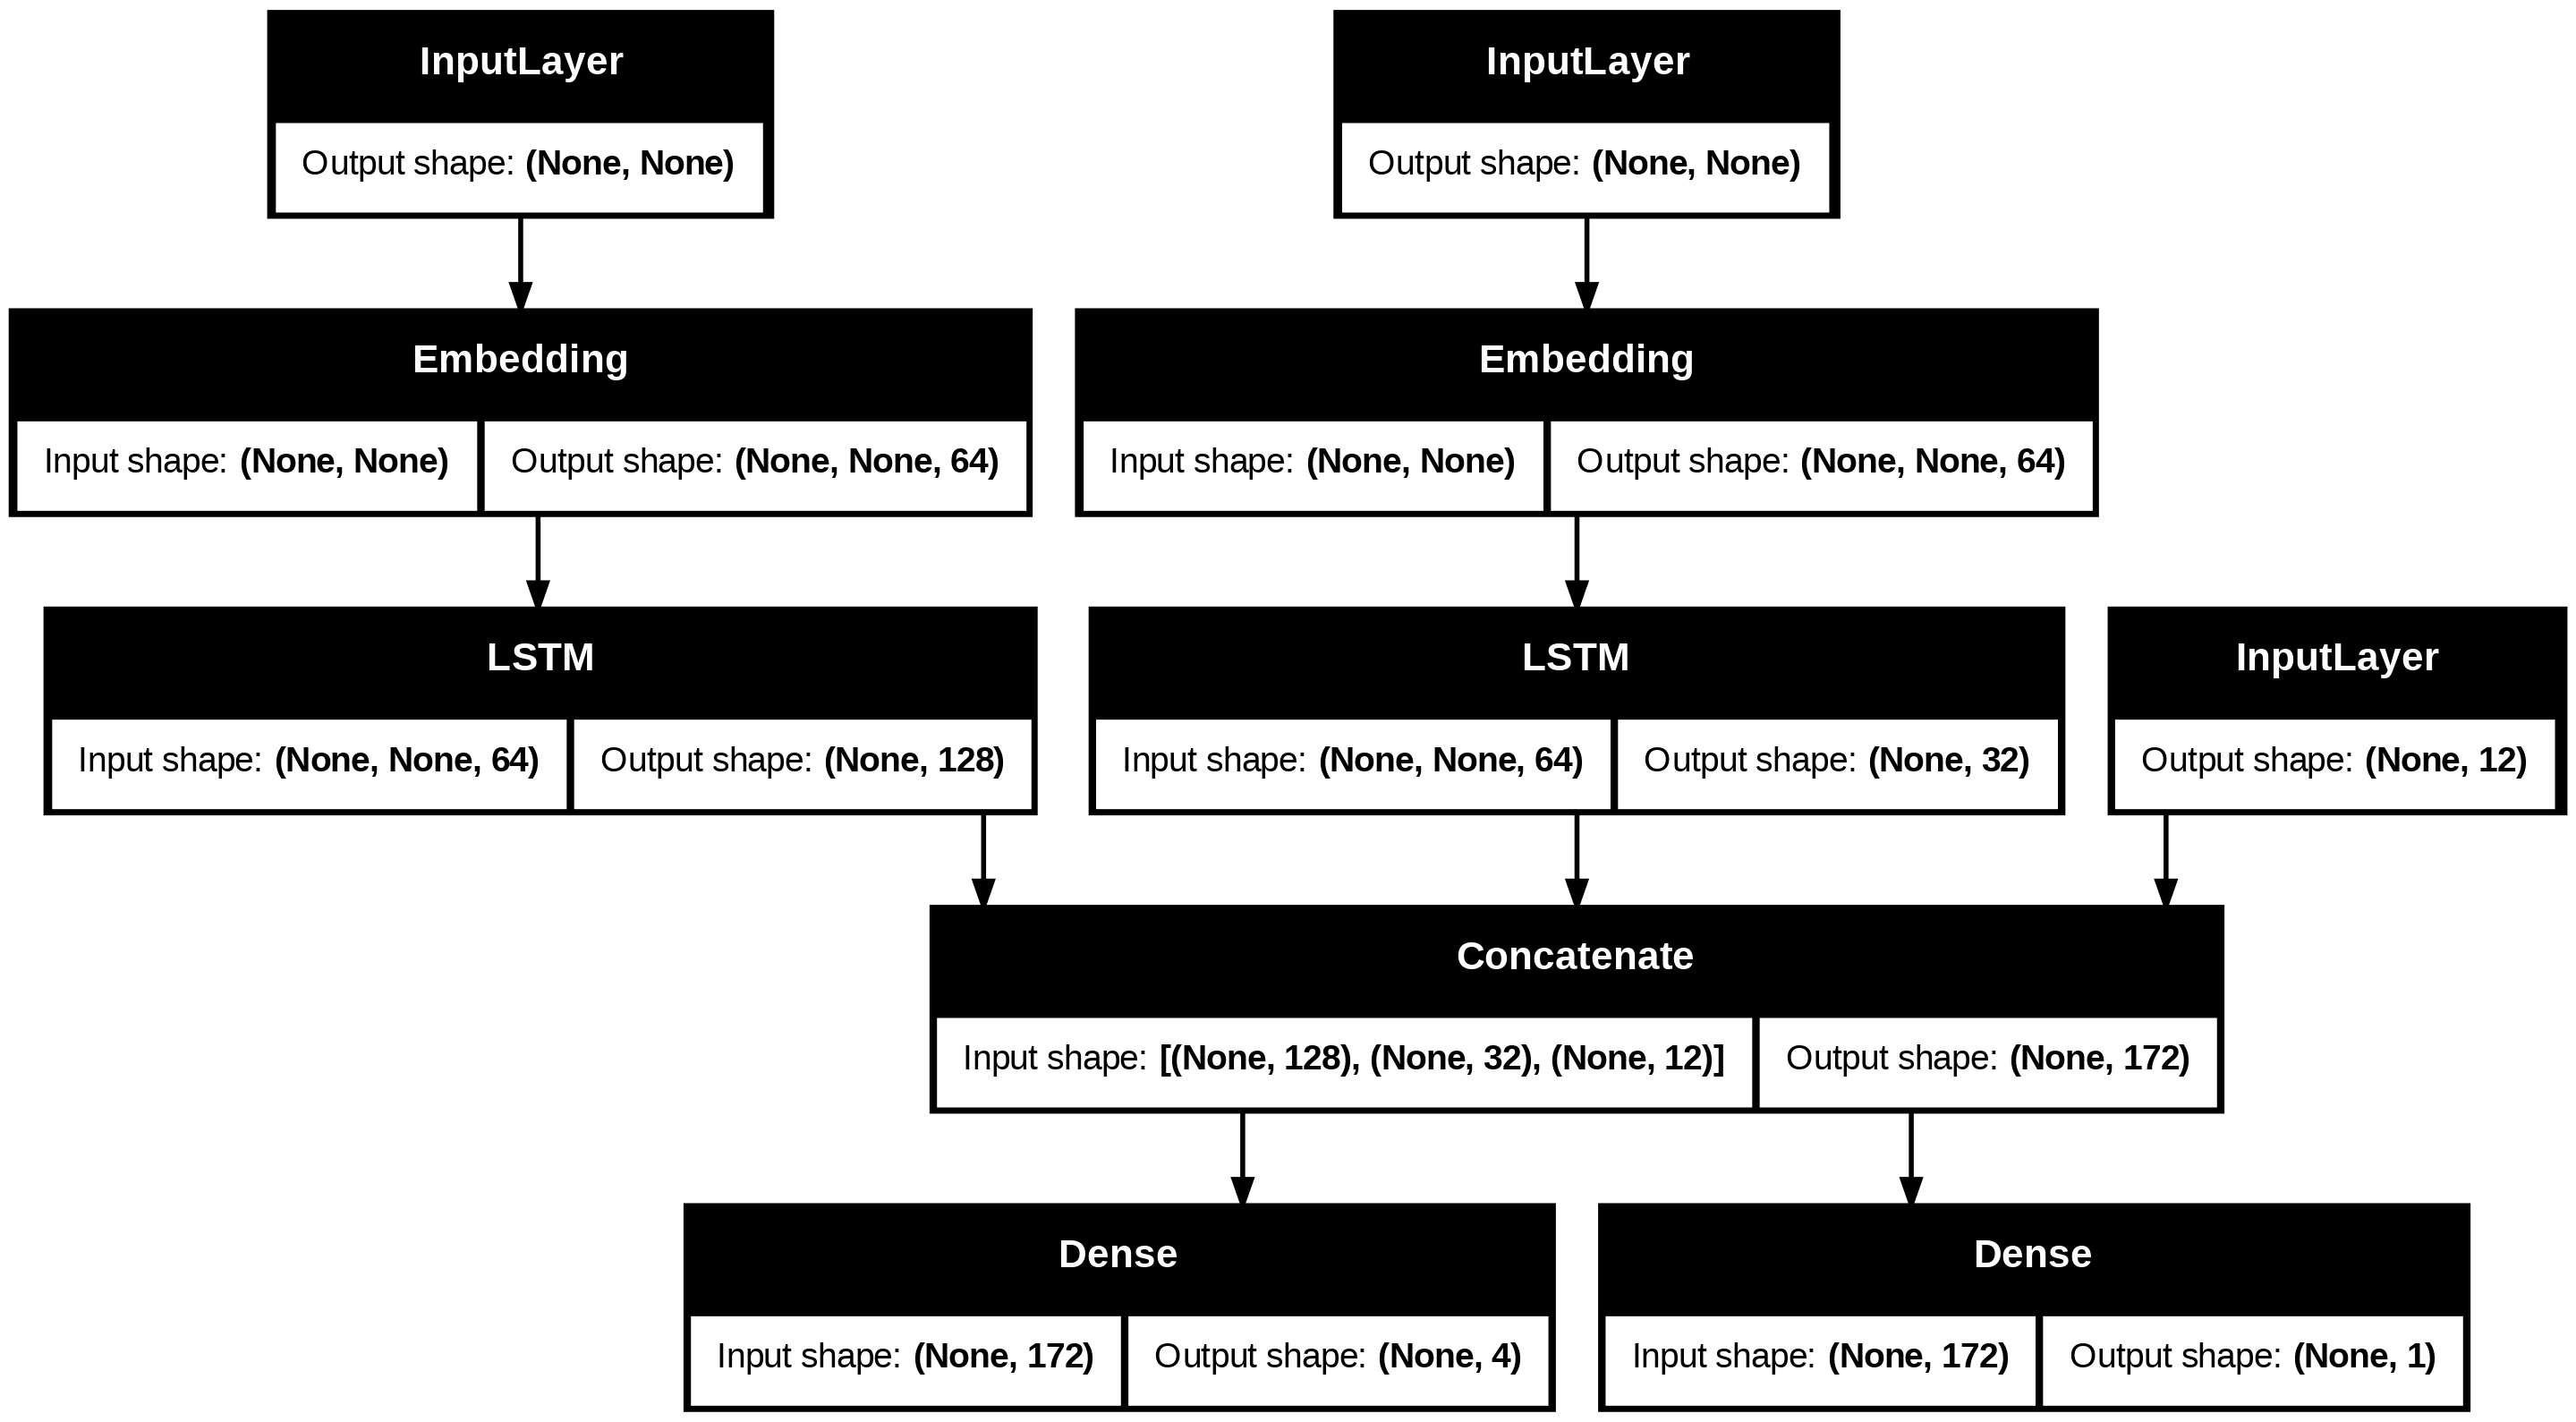

In [19]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

이 모델을 컴파일할 때, 각 출력에 다른 손실을 할당할 수 있습니다.
각 손실에 다른 가중치를 할당하여, 총 트레이닝 손실에 대한 기여도를 조절할 수도 있습니다.


In [20]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True),
    ],
    loss_weights=[1.0, 0.2],
)

출력 레이어의 이름이 다르므로,
해당 레이어 이름으로 손실 및 손실 가중치를 지정할 수도 있습니다.

In [21]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights={"priority": 1.0, "department": 0.2},
)

입력 및 대상의 NumPy 배열 리스트를 전달하여 모델을 트레이닝합니다.

In [22]:
# 더미 입력 데이터
title_data = np.random.randint(num_words, size=(1280, 12))
body_data = np.random.randint(num_words, size=(1280, 100))
tags_data = np.random.randint(2, size=(1280, num_tags)).astype("float32")

# 더미 타겟 데이터
priority_targets = np.random.random(size=(1280, 1))
dept_targets = np.random.randint(2, size=(1280, num_departments))

model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=2,
    batch_size=32,
)

Epoch 1/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - department_loss: 583.1210 - loss: 1348.1504 - priority_loss: 765.0295
Epoch 2/2
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - department_loss: 362.0321 - loss: 762.4374 - priority_loss: 400.4052


`Dataset` 객체로 fit을 호출할 때,
`([title_data, body_data, tags_data], [priority_targets, dept_targets])`와 같은 리스트 튜플이나,
`({'title': title_data, 'body': body_data, 'tags': tags_data}, {'priority': priority_targets, 'department': dept_targets})`와 같은 딕셔너리 튜플을 생성해야 합니다.

자세한 설명은 [트레이닝 및 평가](https://codecompose7.github.io/keras-doc-kr.github.io/guides/training_with_built_in_methods/) 가이드를 참조하세요.

### 토이 ResNet 모델

여러 입력과 출력이 있는 모델 외에도, 함수형 API는 비선형 연결 토폴로지를 쉽게 조작할 수 있게 해줍니다.
이는 순차적으로 연결되지 않은 레이어가 있는 모델로, `Sequential` API에서는 처리할 수 없습니다.

이에 대한 일반적인 사용 사례는 residual 연결입니다.
이를 보여주기 위해, CIFAR10에 대한 토이 ResNet 모델을 빌드해 보겠습니다.

In [23]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)          │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 30, 30, 32)     │            896 │ img[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 28, 28, 64)     │         18,496 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 9, 9, 64)       │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 9, 9, 64)       │         36,928 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 9, 9, 64)       │         36,928 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 9, 9, 64)       │              0 │ conv2d_11[0][0],       │
│                           │                        │                │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 9, 9, 64)       │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 9, 9, 64)       │         36,928 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 9, 9, 64)       │              0 │ conv2d_13[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 7, 7, 64)       │         36,928 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ conv2d_14[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 256)            │         16,640 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 10)             │          2,570 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 223,242 (872.04 KB)

 Trainable params: 223,242 (872.04 KB)

 Non-trainable params: 0 (0.00 B)

모델을 플롯합니다:

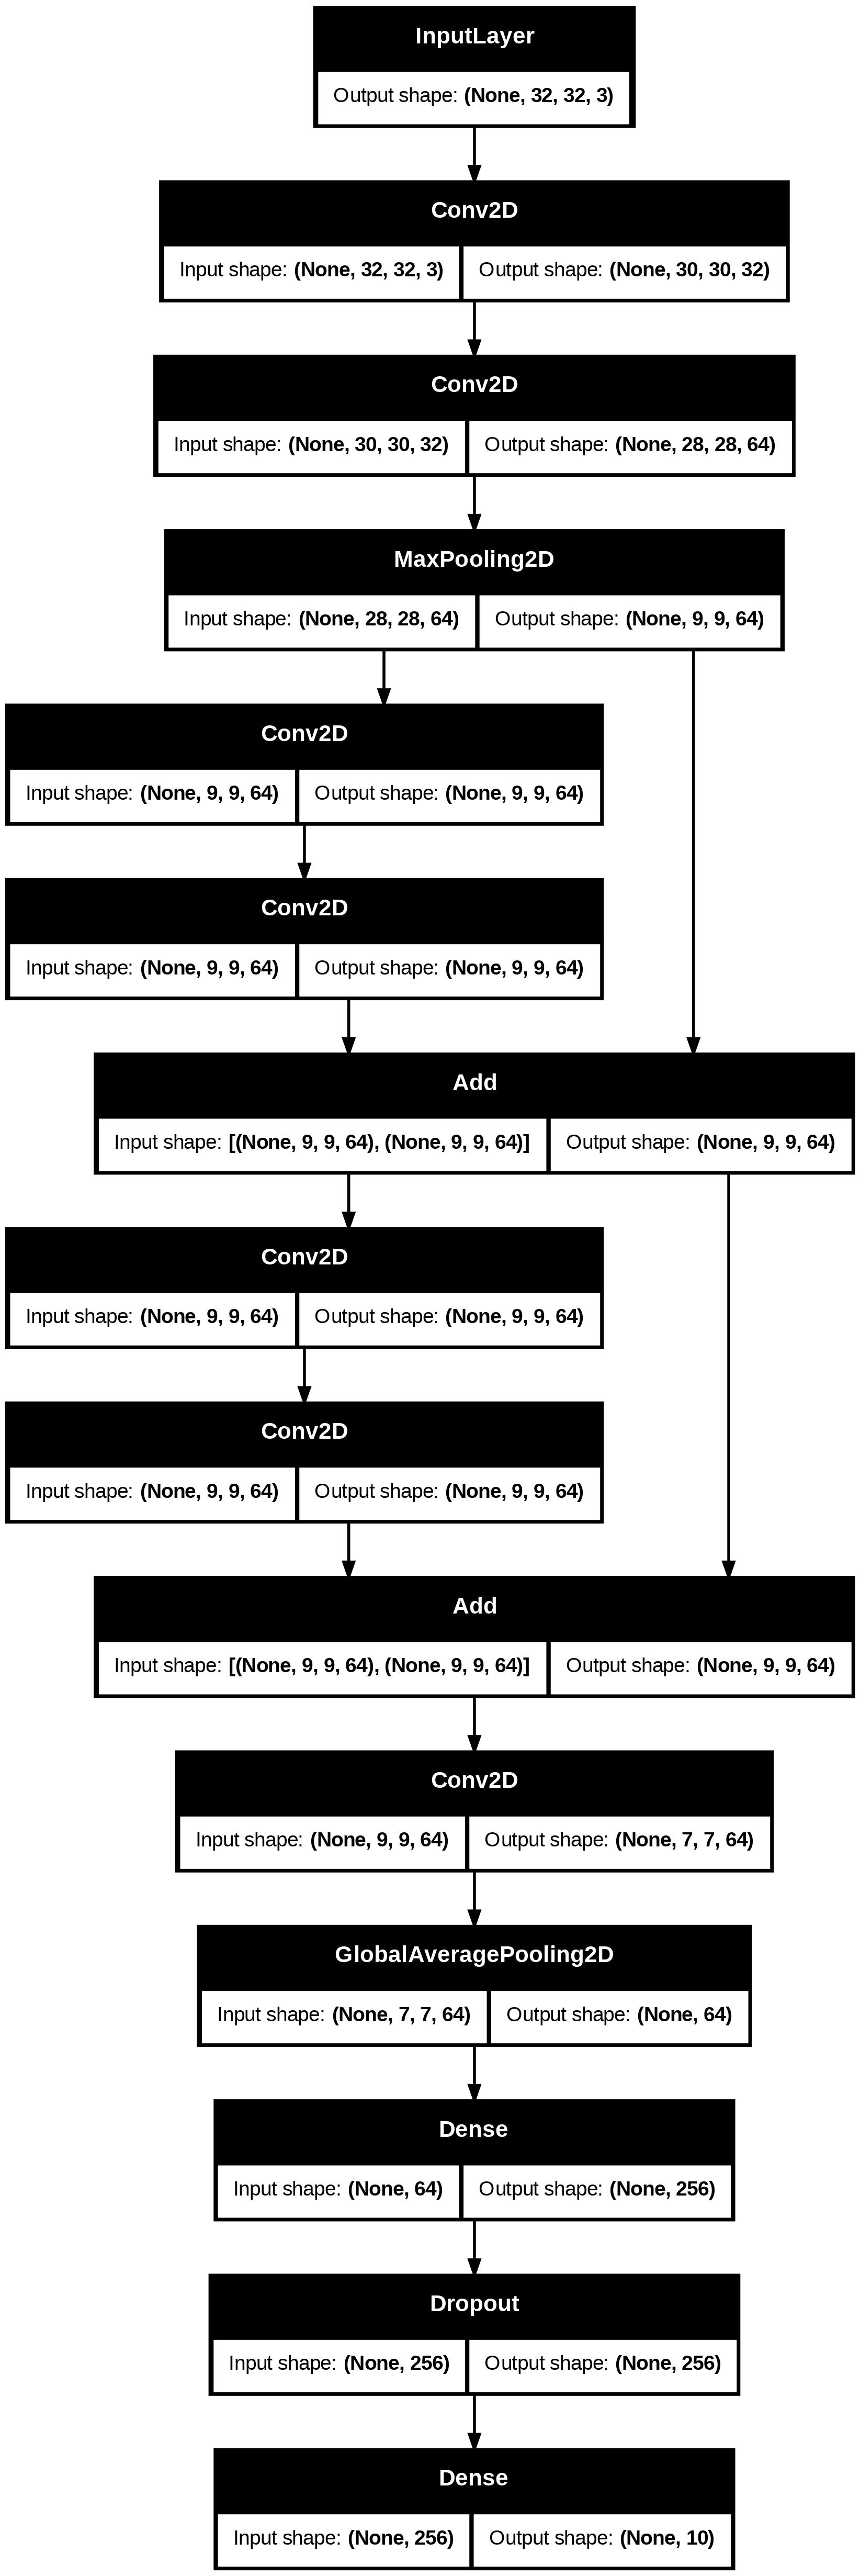

In [24]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

이제 모델을 트레이닝합니다:

In [25]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
# Colab에서 실행 시간을 제한하기 위해 데이터를 처음 1000개 샘플로 제한합니다.
# 수렴할 때까지 전체 데이터 세트에서 트레이닝해 보세요!
model.fit(
    x_train[:1000],
    y_train[:1000],
    batch_size=64,
    epochs=1,
    validation_split=0.2,
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step - acc: 0.1095 - loss: 2.3006 - val_acc: 0.0850 - val_loss: 2.2990


## 공유 레이어

함수형 API의 또 다른 좋은 용도는 _공유 레이어(shared layers)_ 를 사용하는 모델입니다.
공유 레이어는 동일한 모델에서 여러 번 재사용되는 레이어 인스턴스입니다.
레이어 그래프에서 여러 경로에 해당하는 특성을 학습합니다.

공유 레이어는 종종 유사한 공간의 입력을 인코딩하는 데 사용됩니다.
(예: 유사한 어휘를 특성으로 하는 두 개의 서로 다른 텍스트)
이러한 서로 다른 입력에서 정보를 공유할 수 있게 하며,
이러한 모델을 더 적은 데이터로 트레이닝할 수 있게 합니다.
주어진 단어가 입력 중 하나에서 발견되면,
공유 레이어를 통과하는 모든 입력을 처리하는 데 도움이 됩니다.

함수형 API에서 레이어를 공유하려면,
동일한 레이어 인스턴스를 여러 번 호출합니다.
예를 들어, 두 개의 서로 다른 텍스트 입력에서 공유되는 `Embedding` 레이어는 다음과 같습니다.

In [26]:
# 128차원 벡터에 매핑된 1000개의 고유한 단어 임베딩
shared_embedding = layers.Embedding(1000, 128)

# 가변 길이 정수 시퀀스
text_input_a = keras.Input(shape=(None,), dtype="int32")

# 가변 길이 정수 시퀀스
text_input_b = keras.Input(shape=(None,), dtype="int32")

# 동일한 레이어를 재사용하여, 두 입력을 모두 인코딩합니다.
encoded_input_a = shared_embedding(text_input_a)
encoded_input_b = shared_embedding(text_input_b)

## 그래프의 레이어에서 노드 추출 및 재사용

조작하는 레이어의 그래프는 정적 데이터 구조이므로,
액세스하고 검사할 수 있습니다.
그리고 이렇게 해서 함수형 모델을 이미지로 플로팅할 수 있습니다.

이는 또한 중간 레이어(그래프의 "노드")의 활성화에 액세스하여,
다른 곳에서 재사용할 수 있다는 것을 의미합니다.
이는 특성 추출과 같은 작업에 매우 유용합니다.

예를 들어 보겠습니다.
이는 ImageNet에 대해 사전 트레이닝된 가중치가 있는 VGG19 모델입니다.

In [27]:
vgg19 = keras.applications.VGG19()

그리고 이는, 그래프 데이터 구조를 쿼리하여 얻은, 모델의 중간 활성화입니다.

In [28]:
features_list = [layer.output for layer in vgg19.layers]

이러한 특성들을 사용하여, 중간 레이어 활성화 값을 반환하는, 새로운 특성 추출 모델을 만듭니다.

In [29]:
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)

img = np.random.random((1, 224, 224, 3)).astype("float32")
extracted_features = feat_extraction_model(img)

이 기능은 [신경 스타일 전이](https://codecompose7.github.io/keras-doc-kr.github.io/examples/generative/neural_style_transfer/) 등의 작업에 유용합니다.

## 커스텀 레이어를 사용하여 API 확장

`keras`에는 다음과 같은 다양한 빌트인 레이어가 포함되어 있습니다.

* 컨볼루션 레이어: `Conv1D`, `Conv2D`, `Conv3D`, `Conv2DTranspose`
* 풀링 레이어: `MaxPooling1D`, `MaxPooling2D`, `MaxPooling3D`, `AveragePooling1D`
* RNN 레이어: `GRU`, `LSTM`, `ConvLSTM2D`
* `BatchNormalization`, `Dropout`, `Embedding` 등

하지만, 필요한 것을 찾지 못하면, 자체 레이어를 만들어 API를 쉽게 확장할 수 있습니다.
모든 레이어는 `Layer` 클래스를 하위 클래스화하고, 다음을 구현합니다.

* `call` 메서드: 레이어에서 수행되는 계산을 지정
* `build` 메서드: 레이어의 가중치를 생성(`__init__`에서도 가중치를 생성할 수 있으므로, 이는 스타일 규칙일 뿐입니다)

레이어를 처음부터 만드는 방법에 대해 자세히 알아보려면,
[커스텀 레이어 및 모델](https://codecompose7.github.io/keras-doc-kr.github.io/guides/making_new_layers_and_models_via_subclassing) 가이드를 읽어보세요.

다음은 [`keras.layers.Dense`](https://codecompose7.github.io/keras-doc-kr.github.io/api/layers/core_layers/dense#dense-class)의 기본 구현입니다.

In [30]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return ops.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

커스텀 레이어에서 직렬화를 지원하려면,
레이어 인스턴스의 생성자 인수를 반환하는 `get_config()` 메서드를 정의합니다.

In [31]:
class CustomDense(layers.Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return ops.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)
config = model.get_config()

new_model = keras.Model.from_config(config, custom_objects={"CustomDense": CustomDense})

선택적으로, config 딕셔너리를 사용하여 레이어 인스턴스를 재생성할 때 사용되는,
클래스 메서드 `from_config(cls, config)`를 구현합니다.
`from_config`의 기본 구현은 다음과 같습니다.

```python
def from_config(cls, config):
  return cls(**config)
```

## 함수형 API를 사용해야 하는 경우

Keras 함수형 API를 사용하여 새 모델을 만들어야 할까요,
아니면 `Model` 클래스를 직접 서브클래싱해야 할까요?
일반적으로 함수형 API는 더 높은 레벨이고, 더 쉽고, 더 안전하며,
서브클래싱된 모델에서 지원하지 않는 여러 기능이 있습니다.

그러나, 모델 서브클래싱은 레이어의 방향성 비순환 그래프(directed acyclic graphs)로 쉽게 표현할 수 없는 모델을 빌드할 때 더 큰 유연성을 제공합니다.
예를 들어, 함수형 API로 Tree-RNN을 구현할 수 없고,
`Model` 클래스를 직접 서브클래싱해야 합니다.

함수형 API와 모델 서브클래싱의 차이점을 자세히 알아보려면,
[TensorFlow 2.0의 심볼릭 및 명령형 API는 무엇인가?](https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html)를 읽어보세요.

### 함수형 API 강점:

다음 속성은 Sequential 모델(데이터 구조이기도 함)에도 해당하지만,
하위 클래스 모델(데이터 구조가 아닌, Python 바이트코드)에는 해당되지 않습니다.

#### 덜 장황합니다

`super().__init__(...)`도 없고, `def call(self, ...):` 등도 없습니다.

함수형 버전:

```python
inputs = keras.Input(shape=(32,))
x = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10)(x)
mlp = keras.Model(inputs, outputs)
```

서브클래싱된 버전:

```python
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# 모델을 인스턴스화합니다.
mlp = MLP()
# 모델의 상태를 만드는 데 필요합니다.
# 모델은 적어도 한 번 호출될 때까지 상태가 없습니다.
_ = mlp(ops.zeros((1, 32)))
```

#### 연결성 그래프를 정의하는 동안 모델을 검증합니다.

함수형 API에서, 입력 사양(shape 및 dtype)은 미리 생성됩니다. (`Input` 사용)
레이어를 호출할 때마다, 레이어는 전달된 사양이 가정과 일치하는지 확인하고,
일치하지 않으면 유용한 오류 메시지를 표시합니다.

이렇게 하면 함수형 API로 빌드할 수 있는 모든 모델이 실행됩니다.
컨버전스 관련(convergence-related) 디버깅을 제외한 모든 디버깅은,
실행 시간이 아닌 모델 생성 중에 정적으로 발생합니다.
이는 컴파일러의 타입 검사와 유사합니다.

#### 함수형 모델은 플롯이 가능하고 검사가 가능합니다.

모델을 그래프로 그릴 수 있으며,
이 그래프에서 중간 노드에 쉽게 접근할 수 있습니다.
예를 들어, 중간 레이어의 활성화를 추출하여 재사용하려면(이전 예에서 본 것처럼):

```python
features_list = [layer.output for layer in vgg19.layers]
feat_extraction_model = keras.Model(inputs=vgg19.input, outputs=features_list)
```

#### 함수형 모델은 직렬화되거나 복제될 수 있습니다.

함수형 모델은 코드 조각이 아니라 데이터 구조이기 때문에 안전하게 직렬화할 수 있으며,
원본 코드에 액세스하지 않고도 정확히 동일한 모델을 다시 만들 수 있는 단일 파일로 저장할 수 있습니다.
[직렬화 및 저장 가이드](https://codecompose7.github.io/keras-doc-kr.github.io/guides/serialization_and_saving/)를 참조하세요.

하위 클래스된 모델을 직렬화하려면,
구현자가 모델 레벨에서 `get_config()` 및 `from_config()` 메서드를 지정해야 합니다.


### 함수형 API 약점:

#### 동적 아키텍처를 지원하지 않습니다.

함수형 API는 모델을 계층의 DAG로 취급합니다.
이는 대부분의 딥러닝 아키텍처에 해당하지만, 모든 아키텍처에 해당하는 것은 아닙니다.
예를 들어, 재귀적 네트워크나 Tree RNN은 이 가정을 따르지 않으며 함수형 API에서 구현할 수 없습니다.

## API 스타일 혼합 및 매치

함수형 API 또는 모델 서브클래싱 중에서 선택하는 것은,
한 가지 모델 카테고리로 제한하는 이진 결정이 아닙니다.
`keras` API의 모든 모델은 (`Sequential` 모델, 함수형 모델 또는 처음부터 작성된 서브클래싱 모델이든)
서로 상호 작용할 수 있습니다.

항상 함수형 모델 또는 `Sequential` 모델을 서브클래싱 모델 또는 레이어의 일부로 사용할 수 있습니다.

In [32]:
units = 32
timesteps = 10
input_dim = 5

# 함수형 모델 정의
inputs = keras.Input((None, units))
x = layers.GlobalAveragePooling1D()(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


class CustomRNN(layers.Layer):
    def __init__(self):
        super().__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        # 이전에 정의된 함수형 모델
        self.classifier = model

    def call(self, inputs):
        outputs = []
        state = ops.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = ops.stack(outputs, axis=1)
        print(features.shape)
        return self.classifier(features)


rnn_model = CustomRNN()
_ = rnn_model(ops.zeros((1, timesteps, input_dim)))

(1, 10, 32)
(1, 10, 32)


다음 패턴 중 하나를 따르는 `call` 메서드를 구현하는 한,
함수형 API에서 모든 하위 클래스화된 레이어 또는 모델을 사용할 수 있습니다.

* `call(self, inputs, **kwargs)`
  * `inputs`는 텐서 또는 텐서의 중첩 구조(예: 텐서 리스트)
  * `**kwargs`는 텐서가 아닌 인수(입력이 아님)
* `call(self, inputs, training=None, **kwargs)`
  * `training`은 레이어가 트레이닝 모드와 추론 모드에서 동작해야 하는지 여부를 나타내는 boolean
* `call(self, inputs, mask=None, **kwargs)`
  * `mask`는 boolean 마스크 텐서(예를 들어, RNN에 유용함)
* `call(self, inputs, training=None, mask=None, **kwargs)`
  * 물론, 마스킹과 트레이닝 특정 동작을 동시에 가질 수 있습니다.

또한, 커스텀 레이어나 모델에 `get_config` 메서드를 구현하는 경우,
만든 함수형 모델은 여전히 ​​직렬화 및 복제가 가능합니다.

다음은 처음부터 작성된 커스텀 RNN을 함수형 모델에 사용하는 간단한 예입니다.

In [33]:
units = 32
timesteps = 10
input_dim = 5
batch_size = 16


class CustomRNN(layers.Layer):
    def __init__(self):
        super().__init__()
        self.units = units
        self.projection_1 = layers.Dense(units=units, activation="tanh")
        self.projection_2 = layers.Dense(units=units, activation="tanh")
        self.classifier = layers.Dense(1)

    def call(self, inputs):
        outputs = []
        state = ops.zeros(shape=(inputs.shape[0], self.units))
        for t in range(inputs.shape[1]):
            x = inputs[:, t, :]
            h = self.projection_1(x)
            y = h + self.projection_2(state)
            state = y
            outputs.append(y)
        features = ops.stack(outputs, axis=1)
        return self.classifier(features)


# `CustomRNN`의 내부 계산에는 정적 배치 크기가 필요하므로(`state` 제로 텐서를 생성할 때),
# `batch_shape` 인수를 사용하여 입력에 대한 정적 배치 크기를 지정해야 합니다.
inputs = keras.Input(batch_shape=(batch_size, timesteps, input_dim))
x = layers.Conv1D(32, 3)(inputs)
outputs = CustomRNN()(x)

model = keras.Model(inputs, outputs)

rnn_model = CustomRNN()
_ = rnn_model(ops.zeros((1, 10, 5)))